In [156]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Model selection: n-order polynomial regression
In this notebook, we explore what happens when we increase the order of the polynomial to fit to the measured data,
and we assume that the order of the true model is unknown. How can we know when we've hit the right model order?


### Selecting model-order and Generating data
Here we will generate a synthetic dataset from a n-th order polynomial model **$y = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n $** and add some noise, with known distribution, to simulate sampling of the data, giving us **$y_{measured} = y + noise$**,  where:  
$y$ = output  
$u$ = input    
$\theta_{0,1,...,n}$ = model parameters   
$noise$ = measurement noise

Given the generated input data $u$ and the measured data **$y_{measured}$** we will try to estimate the polynomial model coeffitienst $\hat{\theta}_{0,1,...,n}$ using the Least sqaures (LS) and Maximum likelihood estimate (MLE) methods.

### Model-order selection
Although the model order is assumed unknown, we still need something to generate data.

The "params" vector decides the order of the selected model, make sure to put in $n+1$ parameters into the vector for the get a model of order $n$, the first parameter $\theta_0$ is the bias term.

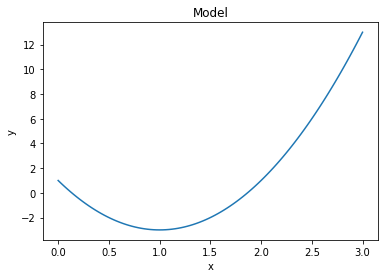

In [157]:
#def arbitrary_poly(params):
#    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
#    return poly_model

def arbitrary_poly(params):
    return np.poly1d(params[::-1])

# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = [1,-8,4]
y_model = arbitrary_poly(true_params)

# Plot true model
x = np.linspace(start=0, stop=3, num=100)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model");

### Measurement noise generation from a chosen distribution
Probability density functions (PDFs):

Gaussian pdf: $P(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

Laplacian pdf: $P(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}$

Hyperparameters to adjust:
- dist: "laplace" or "gauss" : the class of noise-generating distribution.
- mu: The distribution's location parameter (mean value for Gauss).
- sigma: The distribution's scaling parameter (std. for Gauss).
- magnitude: The noise magnitude.
- N: number of samples to generate for the model.

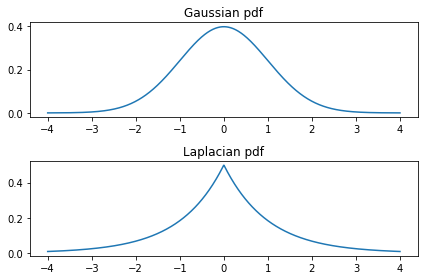

In [158]:
# Hyperparameters for the type of noise-generating distribution.
dist = "gauss"  # choose between "laplace" or "gauss"
loc = 0           # location (mean) parameter 
scale = 1         # scaling (std dev) parameter
magnitude = 1.2   # noise magnitude
N = 100           # number of samples

np.random.seed(123)  # Non-random generation between code executions. Comment out for true random

# The Laplace probability density function:
# Also available in library "scipy.stats.laplace"
def laplace_pdf(x, loc, scale):
    return (1.0/(2.0 * scale)) * np.exp( -np.abs(x-loc) / scale)

# The Gaussian probability density function:
# Also available in library "scipy.stats.norm"
def gauss_pdf(x, loc, scale):
    return 1.0/(scale * np.sqrt(2.0 * np.pi)) * np.exp( -0.5 * ((x - loc) / scale)**2 )

# Plot pdfs:
fig, [ax0, ax1] = plt.subplots(2)

n = np.linspace(start=(loc - 4*scale), stop=(loc + 4*scale), num=1000)  # input range centered around mean of pdf
ax0.plot(n, gauss_pdf(n, loc, scale))
ax0.set_title('Gaussian pdf')
ax1.plot(n,laplace_pdf(n, loc, scale))
ax1.set_title('Laplacian pdf')
plt.tight_layout()
plt.show()

### Data generation:

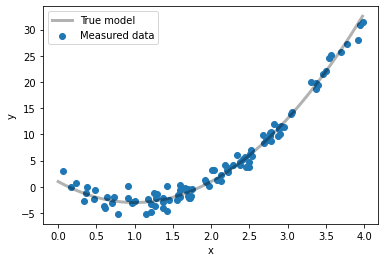

In [159]:
# Generate data points
range_low = 0
range_high = 4
u = np.sort(np.random.uniform(range_low,range_high,N))
y_true = y_model(u)

# Generate noise
from scipy.stats import norm, laplace
if dist == "laplace":
    #pdf = laplace_pdf
    pdf = laplace.pdf
    noise = magnitude * np.random.laplace(loc, scale, N)
elif dist == "gauss":
    #pdf = gauss_pdf
    pdf = norm.pdf
    noise = magnitude * np.random.normal(loc, scale, N)
else:
    raise Exception("Distribution not implemented, choose \"laplace\" or \"gauss\"")

# Add noise to the generated data points - thus simulating measurement
y = y_true + noise

# Plot measured data
plt.scatter(u, y, label=r"Measured data")
u0 = np.linspace(0, max(u), 1000)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

## Least squares regression - LS
### Given the sampled data we can estimate the underlying polynomial model using LS regression
Solution to a least squares problem is given by the normal equation:
$\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$

### Step 1 - rewrite the model in matrix form to get the data tensor u
$y_{measured} = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n  + noise =   [1 \; u^1 \; .. \; u^n] \cdot [ \theta_0 \; \theta_1 \; .. \; \theta_n ] ^T + noise$

$\mathbf{u} = [1 \; u^1 \; .. \; u^n]$

If the model order is unknown, we can investigate a range of orders and determine the best fit.

In [160]:
# Guess what order the model is:
order_guesses = np.arange(2,6, dtype="int") # number coincides with # of parameters, i.e. (order-1)

# Find LS solution - Step 1:
u_tensor_0 = np.reshape(u,(N,1))
ones_vec = np.ones((N,1))

U = []  # Container for input vectors for all model orders.
for o in order_guesses:
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)  # Reset to 1st order
    for i in range(2,o):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)
    U.append(u_tensor)

LS_params = []
for _u in U:
    # Step 2-4 described in previous notebooks, but in one line.
    LS_params.append(np.dot(np.linalg.inv(np.dot(_u.T,_u)), np.dot(_u.T,y)))

print(f"True model parameters:\n{y_model}\n")
for i, params in enumerate(LS_params):
    print(f"LS fitted model of order", i+1, f":\n {arbitrary_poly(params)}\n")


True model parameters:
   2
4 x - 8 x + 1

LS fitted model of order 1 :
  
8.042 x - 11.19

LS fitted model of order 2 :
        2
3.956 x - 7.933 x + 1.126

LS fitted model of order 3 :
          3         2
-0.2234 x + 5.326 x - 10.26 x + 2.07

LS fitted model of order 4 :
          4          3         2
0.02016 x - 0.3882 x + 5.766 x - 10.69 x + 2.175



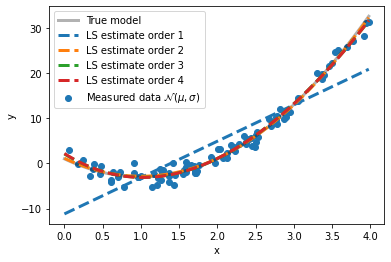

In [161]:
# Recreate models based on LS parameters:
LS_estimates = []
for params in LS_params:
    LS_estimates.append(arbitrary_poly(params))

# Plot true vs. estimated models
plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
u0 = np.linspace(0, max(u), 100)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
for i, LS_estimate in enumerate(LS_estimates):
    plt.plot(u0, LS_estimate(u0), "--",  lw=3, label="LS estimate order {}".format(i+1))
#plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

### Generalizability
Although the fitted models all look decent, what happens if we look outside the range of the measurements? In the figure
below, only one of the models closely match the true model.

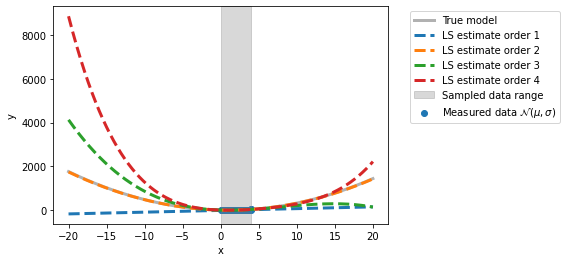

In [162]:
# Plot true vs. estimated models
plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
plt.axvspan(range_low, range_high, alpha=0.3, color="gray", label="Sampled data range")

u0 = np.linspace(-20, 20, 1000)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
for i, LS_estimate in enumerate(LS_estimates):
    plt.plot(u0, LS_estimate(u0), "--",  lw=3, label="LS estimate order {}".format(i+1))
#plt.xlim(0, 10)
#plt.ylim(bottom=min(y_model(u0)), top=max(y_model(u0)))
#plt.yscale('log')
#plt.xscale('log')
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
plt.xlabel("x")
plt.ylabel("y");

## Maximum likelihood estimation regression - MLE
Let's do the same for MLE:

Based on code from: http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/3-4-UnivarMLE.html

In [163]:
import scipy.optimize as optimize

def log_lik(par_vec, y, x):
    global pdf  # Use the distribution class chosen earlier
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
              loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale = par_vec[-1])
    
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

MLE_estimates = []
print("True model parameters:\n", y_model)
for n in order_guesses:
    # The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
    # therefore the initial guess vector has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
    init_guess = np.zeros(n+1)
    init_guess[-1] = N


    # Do Maximum Likelihood Estimation:
    opt_res = optimize.minimize(fun = log_lik,
                                x0 = init_guess,
                                #options={'disp': True},
                                args = (y, u))

    params = opt_res.x[:-1]
    MLE_estimate = arbitrary_poly(params)
    MLE_estimates.append(MLE_estimate)

    print("MLE ", n-1, "-order fitted model:\n", MLE_estimate, "\n", sep="")

True model parameters:
    2
4 x - 8 x + 1
MLE 1-order fitted model:
 
8.042 x - 11.19

MLE 2-order fitted model:
       2
3.956 x - 7.933 x + 1.126

MLE 3-order fitted model:
         3         2
-0.2234 x + 5.326 x - 10.26 x + 2.07

MLE 4-order fitted model:
         4          3         2
0.02015 x - 0.3881 x + 5.766 x - 10.69 x + 2.175



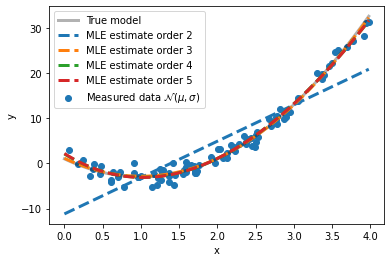

In [164]:
# Plot true vs. estimated models
plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
u0 = np.linspace(0, max(u), 100)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
for i, MLE_estimate in enumerate(MLE_estimates):
    plt.plot(u0, MLE_estimate(u0), "--",  lw=3, label="MLE estimate order {}".format(order_guesses[i]))
#plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

Which order for the fitted model is the best choice?

---

### Generalizability
Again, looking outside the sampled data, we se something similar to the LS solutions.

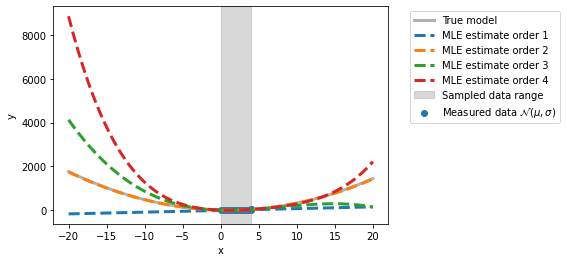

In [165]:
# Plot true vs. estimated models
plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
plt.axvspan(range_low, range_high, alpha=0.3, color="gray", label="Sampled data range")

u0 = np.linspace(-20, 20, 1000)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
for i, MLE_estimate in enumerate(MLE_estimates):
    plt.plot(u0, MLE_estimate(u0), "--",  lw=3, label="MLE estimate order {}".format(i+1))
#plt.xlim(0, 10)
#plt.ylim(bottom=min(y_model(u0)), top=max(y_model(u0)))
#plt.yscale('log')
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
plt.xlabel("x")
plt.ylabel("y");

### Calculating (Root mean square error) RMSE for LS and MLE

**RMSE** = $\sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\big({\hat{y}_i - y_{i}}\big)^2}}$

Will RMSE give an accurate measure for the best model? A lower RMSE is not necessarily better:

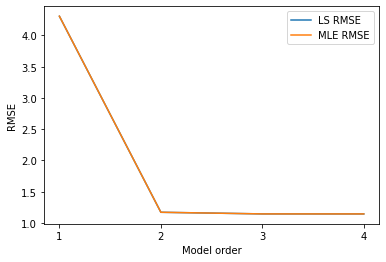

In [166]:
def rmse(y_hat,y):
    return np.sqrt(np.mean((y_hat-y)**2))

RMSE_LS = []
RMSE_MLE = []

# Calculate RMSE for all of the fitted models:
for i, (_mle, _ls) in enumerate(zip(MLE_estimates, LS_estimates)):
    RMSE_LS.append(rmse(_mle(u),y))
    RMSE_MLE.append(rmse(_ls(u),y))

plt.figure()
plt.plot(order_guesses-1, RMSE_LS, label="LS RMSE")
plt.plot(order_guesses-1, RMSE_MLE, label="MLE RMSE")
plt.legend()
plt.xlabel("Model order")
plt.xticks(order_guesses-1)
plt.ylabel("RMSE")
plt.show()

Increasing the model complexity (i.e. order) increases the risk of *overfitting* the data. Although the RMSE looks
slightly better for higher order models, we saw earlier that the high-order models don't generalize very well to unseen data.

In practice, we may not know the order of the true model. A general rule of thumb for model selection is to keep the
model complexity as low as possible while still achieving a *reasonable* fit. In this plot, it is clear that increasing the
model order beyond 2 gives diminishing returns.